# Find Cointegrated Pairs

Procura e prepara pares cointegrados e organiza um DataFrame com todas as informações para serem analisadas e decisão de entrada

In [6]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

# Functions/Methods

Salva as funções em Cointegration.py para serem usadas em outros notebook

In [7]:
#%%writefile Cointegration.py

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics
import os.path
import matplotlib.pyplot as plt

"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        statistic = model[0]
        
        # Dickey-Fuller
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        
        # Augmented Dickey Fuller (ADF)
        if (abs(statistic) > abs(model[4]['1%'])):
            self.perc_stat = 99
        elif (abs(statistic) > abs(model[4]['5%'])):
            self.perc_stat = 95
        elif (abs(statistic) > abs(model[4]['10%'])):
            self.perc_stat = 90
        else:
            self.perc_stat = 0

        return self.is_stationary

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

"""
Check cointegrated pairs from dataframe
"""
def find_cointegrated_pairs(data, period=250, check_other_periods=True):
    rows = []
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
                
            y_values = data[y_symbol]
            x_values = data[x_symbol]
            
            # filter by period
            y, x = getvalues_by_period(y_values, x_values, period)
            coint = cointegration(y, x, 0)
            
            # check is stationary
            if (coint['is_stationary'] == True):
                rows.append([len(x), y_symbol, x_symbol, coint['p_value'], coint['perc_stat'], coint['beta']])
                
            # 28/06/2020
            # se não tá cointegrado no período principal, verifica se tá em outro
            if (coint['is_stationary'] == False and check_other_periods == True):
                for per in [250, 240, 220, 200, 180, 160, 140, 120, 100]:
                    res_dic = cointegration(y_values, x_values, per)

                    # só precisa saber que tá cointregado em algum período
                    if (res_dic['is_stationary'] == True):
                        rows.append([per, y_symbol, x_symbol, res_dic['p_value'], res_dic['perc_stat'], res_dic['beta']])
                        break

    # create DataFrame
    df_pairs = pd.DataFrame(rows, columns=['Period', 'Dependente', 'Independente', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

"""
Check cointegration in values Y vs X by period
"""
def cointegration(y, x, period = 250):
    adf = DickeyFuller()
    if (period == 0):
        period = len(y)

    y, x = getvalues_by_period(y, x, period)
    model = model_ols(y, x)
    adf.check(model.resid)
    return {"is_stationary": adf.is_stationary,
            "p_value": adf.p_value,
            "perc_stat": adf.perc_stat,
            "beta": model.params[1],
            "coefang": model.params[1],
            "coeflinear": model.params[0],
            "period": period}

"""
Apply various periods in DataFrame of the pairs
"""
def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        analysis = analysis_by_periods(y, x)
        stationary = analysis.loc[(analysis['Stationary'])]

        des = ''
        for j, row in stationary.iterrows():
            if (des!=''):
                des=des+','
            des=des+str(row['Period'])

        pairs['PeriodQt'].iloc[i] = stationary.shape[0]
        pairs['PeriodStr'].iloc[i] = des

"""
Check analysis of the periods: 100, 120, 140, 160 ... 250
"""
def analysis_by_periods(y, x):
    rows=[]
    adf = DickeyFuller()
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        # filter by period
        y_values, x_values = getvalues_by_period(y, x, period)

        res_dic = cointegration(y_values, x_values, 0)
        half_life = check_halflife(y_values, x_values)
        hurst = check_hurst(y_values, x_values)
        corr = corr_pearson(y_values, x_values)

        rows.append([period, res_dic['is_stationary'], res_dic['p_value'], res_dic['perc_stat'], res_dic['beta'], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

"""
Return em log
"""
def return_varlog(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = np.log(time_series/lag)
    ret[0] = 0
    return ret

"""
Apply half-life
"""
def apply_halflife(data, pairs, period = 250):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value

"""
Check and return half-life
"""
def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

"""
Apply hurst coefficient
"""
def apply_hurst(data, pairs, period=250):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value

"""
Check and return hurst coefficient
"""
def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.values)

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x, inlog=False):
    if inlog:
        y = return_varlog(y)
        x = return_varlog(x)
    
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

"""
Apply correlation in DataFrame of the pairs
"""
def apply_corr(data, pairs, period=250):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        corr = corr_pearson(y, x, True)
        pairs['Corr'].iloc[i] = corr

"""
Check signal
"""
def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'Short/Long'
        zcurrent = zscore_up
    else:
        desc = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

"""
Apply signal in DataFrame of the pairs
"""
def apply_signal(data, pairs, period=250):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[2]
        pairs['SignalStr'].iloc[i] = sig[0]

"""
Check periods
"""
def check_periods(data, y_symbol, x_symbol, period):
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

"""
Check a single period
"""
def check_oneperiod(data, y_symbol, x_symbol, period):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary]

"""
Search and return values by period
"""
def getvalues_by_period(y, x, period):
    if(period <= 0):
        return y, x
    
    n = len(y)
    if(period < n):
        pos = n-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    return y, x

"""
Standardize by z-score
"""
def zscore(series):
    return (series - series.mean()) / np.std(series)

"""
Limpar pasta da imagem
"""
def clear_folder(pathdir):
    for file in os.listdir(pathdir):
        filename = '{}/{}'.format(pathdir, file)
        if os.path.exists(filename):
            os.remove(filename)

def volatility(prices, periods=0):
    if (periods > 0):
        prices = prices[0:periods+1]# +1, pq haverá um lag(d-1)
    log = np.log(prices/prices.shift(1))
    vol = log.std() * np.sqrt(252)
    return vol

"""
Show graphic
"""
def show(data, y_symbol, x_symbol, period=250, padronizar=True, savefig=''):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    model= model_ols(y, x)
    result = model.resid
    
    # padronizar porque a taxa absoluta pode não ser a maneira mais ideal de analisar
    if(padronizar):
        result = zscore(model.resid)
        
    std = statistics.stdev(result)
    entry_threshold = 2 # entrada em 2 desvio padrão
    
    result.plot(figsize=(15,6))
    plt.ylabel('Residual')
    if(y_symbol != '' and x_symbol != ''):
        plt.title('{} / {}'.format(y_symbol, x_symbol))

    #purple
    plt.axhline(0, color='black',label='mean') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='red', linestyle='--', linewidth=2)
    plt.axhline(-entry_threshold*std, color='green', linestyle='--', linewidth=2)
    plt.xlabel('')

    plt.grid(True)
    plt.margins(0.1)
    if(savefig!=''):
        plt.savefig(savefig)

    #plt.legend()
    plt.show()

In [8]:
%matplotlib inline

## Read CSV

In [9]:
path_data_cart = 'datasets/data_cart.csv'
path_data_full = 'datasets/data.csv'
path_data_alpha = 'datasets/data_alpha.csv'

In [10]:
df = pd.read_csv(path_data_cart, index_col=0)
#df = df[:-1].copy()
data = df[df.columns.difference(['Data', 'Date'])]
data.shape, 'from {} to {}'.format(data.index[0], data.index[-1])

((300, 71), 'from 16/04/2019 to 30/06/2020')

In [11]:
pairs = find_cointegrated_pairs(data)
pairs

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta
0,250,ABEV3,BBAS3,0.037675,95,0.299402
1,250,ABEV3,BBDC3,0.034782,95,0.435028
2,250,ABEV3,BBDC4,0.014999,95,0.409048
3,250,ABEV3,BBSE3,0.043883,95,0.605793
4,180,ABEV3,BRDT3,0.045962,95,0.557275
...,...,...,...,...,...,...
1060,250,UGPA3,VIVT4,0.013770,95,0.803530
1061,100,UGPA3,WEGE3,0.044044,95,0.514823
1062,250,USIM5,VIVT4,0.007456,99,0.359113
1063,100,USIM5,WEGE3,0.046687,90,0.244045


In [12]:
apply_halflife(data, pairs)
print('Half-Life applied successfully')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Half-Life applied successfully


In [13]:
apply_hurst(data, pairs)
print('Hurst applied successfully')

Hurst applied successfully


In [14]:
apply_corr(data, pairs)
print('Correlation applied successfully')

Correlation applied successfully


In [15]:
apply_signal(data, pairs)
print('Signal applied successfully')

Signal applied successfully


In [16]:
apply_periods(data, pairs)

In [17]:
pairs

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr,PeriodQt,PeriodStr
0,250,ABEV3,BBAS3,0.037675,95,0.299402,11,0.428624,0.551971,0.335729,Short/Long,3,"100,180,250"
1,250,ABEV3,BBDC3,0.034782,95,0.435028,12,0.404660,0.578798,0.664004,Short/Long,6,"160,180,200,220,240,250"
2,250,ABEV3,BBDC4,0.014999,95,0.409048,10,0.391442,0.563921,0.697902,Short/Long,5,"180,200,220,240,250"
3,250,ABEV3,BBSE3,0.043883,95,0.605793,11,0.291332,0.451022,0.115516,Short/Long,8,"100,120,140,160,180,200,220,250"
4,180,ABEV3,BRDT3,0.045962,95,0.557275,15,0.471740,0.578768,0.059313,Long/Short,2,"100,180"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,250,UGPA3,VIVT4,0.013770,95,0.803530,12,0.322084,0.541196,0.739756,Short/Long,3,"220,240,250"
1061,100,UGPA3,WEGE3,0.044044,95,0.514823,42,0.626840,0.559695,0.182552,Long/Short,1,100
1062,250,USIM5,VIVT4,0.007456,99,0.359113,10,0.262354,0.400708,0.694476,Short/Long,5,"180,200,220,240,250"
1063,100,USIM5,WEGE3,0.046687,90,0.244045,39,0.589588,0.459613,0.072644,Short/Long,1,100


In [18]:
pairs.to_csv('datasets/cointegrated_pairs.csv', index=False)
print('Saved successfully!!!')

Saved successfully!!!


# Exemplo
Agora é só usar o cointegrated_pairs.csv para fazer as diversas análises que desejar

In [19]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv')

Teste de visualização

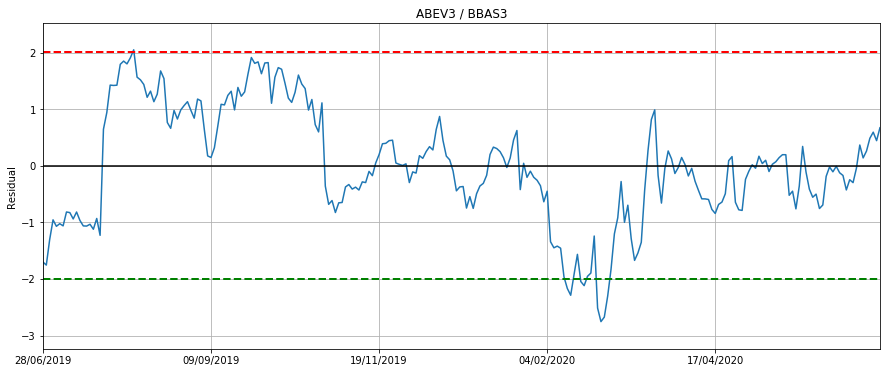

In [20]:
show(data, pairs['Dependente'][0], pairs['Independente'][0])